# 1. Data Ingestion and Exploratory Data Analysis

In [11]:
# Option 1: Use setup script (recommended)
# import sys; sys.path.append('..'); from setup_env import setup_environment; setup_environment()

# Option 2: Manual setup
import sys
import os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.snowflake_connector import get_snowflake_engine, fetch_data
from src.config import get_config

print("🚀 Setting up configuration and data connection...")

# Load configuration
config = get_config()
print(f"📋 Available config sections: {list(config.sections())}")
print(f"📊 Target table: {config['snowflake']['table_name']}")
print(f"🎯 Target column: {config['model']['target_column']}")

# Connect to Snowflake and fetch data
engine = get_snowflake_engine()
df = fetch_data(engine, config['snowflake']['table_name'])
print(f"✅ Data loaded successfully! Shape: {df.shape}")

🚀 Setting up configuration and data connection...
✅ Configuration loaded from: /Users/eyalbenzion/Library/CloudStorage/GoogleDrive-eyal.benzion@gmail.com/My Drive/work_code/bounce_loan_prediction/config.ini
📋 Available config sections: ['snowflake', 'model', 'business']
📊 Target table: PREDICT_RECOVERY
🎯 Target column: ENROLLED_TO_PLAN_IN_180
2025-06-27 15:40:35,719 - src.data.snowflake_connector - INFO - Connecting to Snowflake account: fc26424.us-east-2.aws
2025-06-27 15:40:35,720 - src.data.snowflake_connector - INFO - Using database: BOUNCE_ASSIGNMENT, schema: PUBLIC, warehouse: BOUNCE_GUEST
2025-06-27 15:40:35,721 - src.data.snowflake_connector - INFO - Successfully created Snowflake engine.
2025-06-27 15:40:40,890 - src.data.snowflake_connector - INFO - Successfully fetched data from PREDICT_RECOVERY.
✅ Data loaded successfully! Shape: (34628, 21)


## Initial Data Exploration

In [2]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34628 entries, 0 to 34627
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   account_public_id                           34628 non-null  object 
 1   principal_at_placement                      34628 non-null  float64
 2   total_principal_ratio                       34628 non-null  float64
 3   total_at_placement                          34628 non-null  float64
 4   days_from_co_to_placement                   34628 non-null  int64  
 5   days_from_origination_to_placement          34628 non-null  int64  
 6   days_from_dq_to_placement                   34628 non-null  int64  
 7   days_from_origination_to_co                 34628 non-null  int64  
 8   days_from_last_payment_to_assignment        34628 non-null  int64  
 9   is_fpd                                      34628 non-null  bool   
 10  group_    

## Extensive Exploratory Data Analysis

Let's dive deep into understanding our dataset for loan repayment prediction.

### 1. Dataset Overview and Basic Statistics


In [3]:
# Set plotting style for better visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display basic information about the dataset
print("="*50)
print("📊 DATASET OVERVIEW")
print("="*50)
print(f"Total records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data types summary
print("\n📈 DATA TYPES SUMMARY:")
print(df.dtypes.value_counts())

# Basic statistics for numerical columns
print("\n📊 NUMERICAL FEATURES SUMMARY:")
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numerical_cols].describe())


📊 DATASET OVERVIEW
Total records: 34,628
Total features: 21
Memory usage: 9.92 MB

📈 DATA TYPES SUMMARY:
float64    11
int64       6
object      3
bool        1
Name: count, dtype: int64

📊 NUMERICAL FEATURES SUMMARY:
       principal_at_placement  total_principal_ratio  total_at_placement  \
count            34628.000000           34628.000000        34628.000000   
mean              8446.258515               1.105600         9243.014682   
std               6764.144830               0.047949         7237.147526   
min                 24.720000               1.000000           28.800000   
25%               3265.992500               1.072352         3638.287500   
50%               6116.010000               1.102924         6832.225000   
75%              11376.437500               1.142043        12436.925000   
max              40000.000000               1.708522        42994.690000   

       days_from_co_to_placement  days_from_origination_to_placement  \
count               34628

### 2. Missing Values Analysis


🔍 MISSING VALUES ANALYSIS:
                                    Column  Missing_Count  Missing_Percentage
                   enrolled_to_plan_in_180           2214            6.393670
   sum_of_balance_amount_installment_loans            101            0.291671
          bank_card_credit_utilization_pct            101            0.291671
        revolving_accounts_opened_3_months            101            0.291671
installment_loans_accounts_opened_3_months            101            0.291671
              thirty_dpd_in_last_24_months            101            0.291671
             total_accounts_in_collections            101            0.291671
       total_finance_accounts_balance_gt_0            101            0.291671
              total_paid_accounts_6_months            101            0.291671


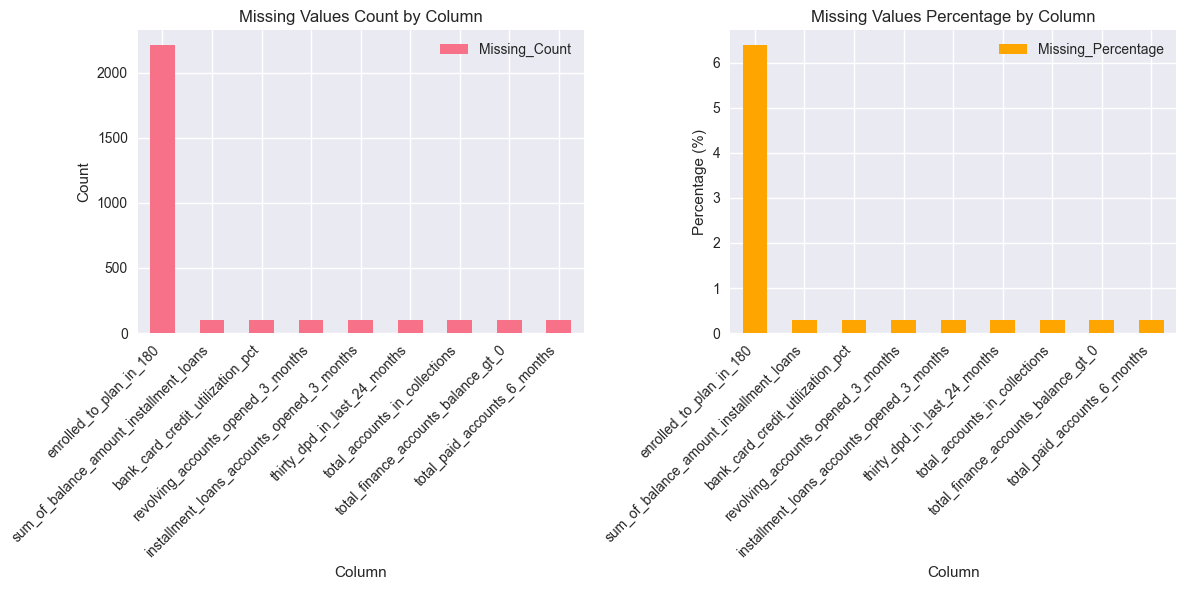

In [4]:
# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})

# Filter columns with missing values
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("🔍 MISSING VALUES ANALYSIS:")
print("="*50)
if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
    
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    missing_data.plot(x='Column', y='Missing_Count', kind='bar', ax=plt.gca())
    plt.title('Missing Values Count by Column')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    missing_data.plot(x='Column', y='Missing_Percentage', kind='bar', ax=plt.gca(), color='orange')
    plt.title('Missing Values Percentage by Column')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage (%)')
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found in the dataset!")


### 3. Target Variable Analysis


🎯 TARGET VARIABLE ANALYSIS: enrolled_to_plan_in_180
Unique values: [False None True]
Data type: object

📊 TARGET DISTRIBUTION:
Total non-null records: 32,414
Records with missing target: 2,214
  False: 27,191 (83.89%)
  True: 5,223 (16.11%)


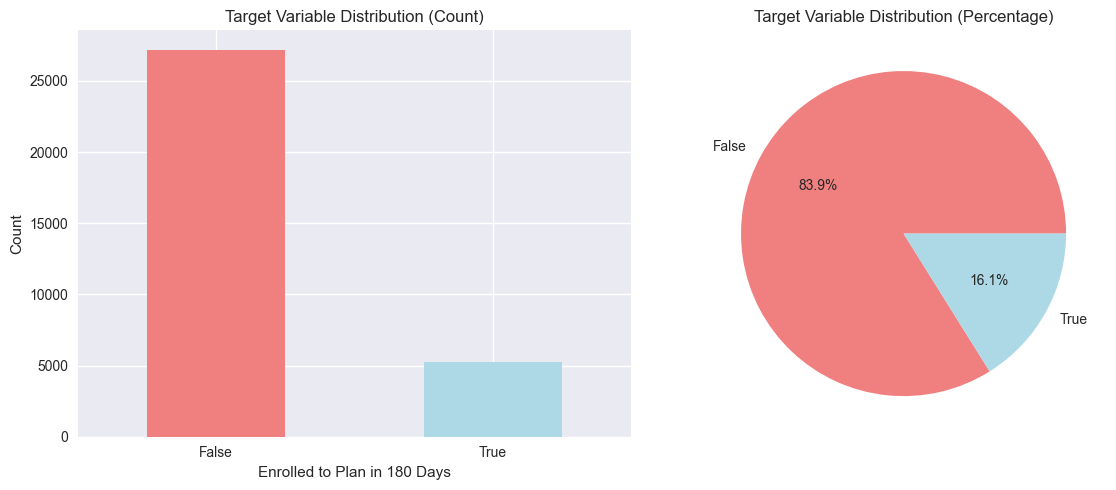


⚖️ CLASS BALANCE:
Imbalance ratio: 0.192
⚠️ Moderate class imbalance detected


In [5]:
# Target variable analysis
target_col = config['model']['target_column'].lower()
print(f"🎯 TARGET VARIABLE ANALYSIS: {target_col}")
print("="*60)

# Check unique values and data type
print(f"Unique values: {df[target_col].unique()}")
print(f"Data type: {df[target_col].dtype}")

# Convert to boolean if needed and handle missing values
df_clean = df.dropna(subset=[target_col])
target_values = df_clean[target_col]

# Convert string boolean to actual boolean
if target_values.dtype == 'object':
    target_values = target_values.map({'True': True, 'False': False, True: True, False: False})

# Calculate target distribution
target_counts = target_values.value_counts()
target_percentages = target_values.value_counts(normalize=True) * 100

print(f"\n📊 TARGET DISTRIBUTION:")
print(f"Total non-null records: {len(target_values):,}")
print(f"Records with missing target: {df[target_col].isnull().sum():,}")

for value, count in target_counts.items():
    percentage = target_percentages[value]
    print(f"  {value}: {count:,} ({percentage:.2f}%)")

# Visualize target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
target_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Target Variable Distribution (Count)')
plt.xlabel('Enrolled to Plan in 180 Days')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
target_percentages.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Target Variable Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Check class imbalance
imbalance_ratio = target_counts.min() / target_counts.max()
print(f"\n⚖️ CLASS BALANCE:")
print(f"Imbalance ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.1:
    print("⚠️ Severe class imbalance detected!")
elif imbalance_ratio < 0.3:
    print("⚠️ Moderate class imbalance detected")
else:
    print("✅ Classes are relatively balanced")


### 4. Numerical Features Analysis


📊 NUMERICAL FEATURES ANALYSIS (17 features)


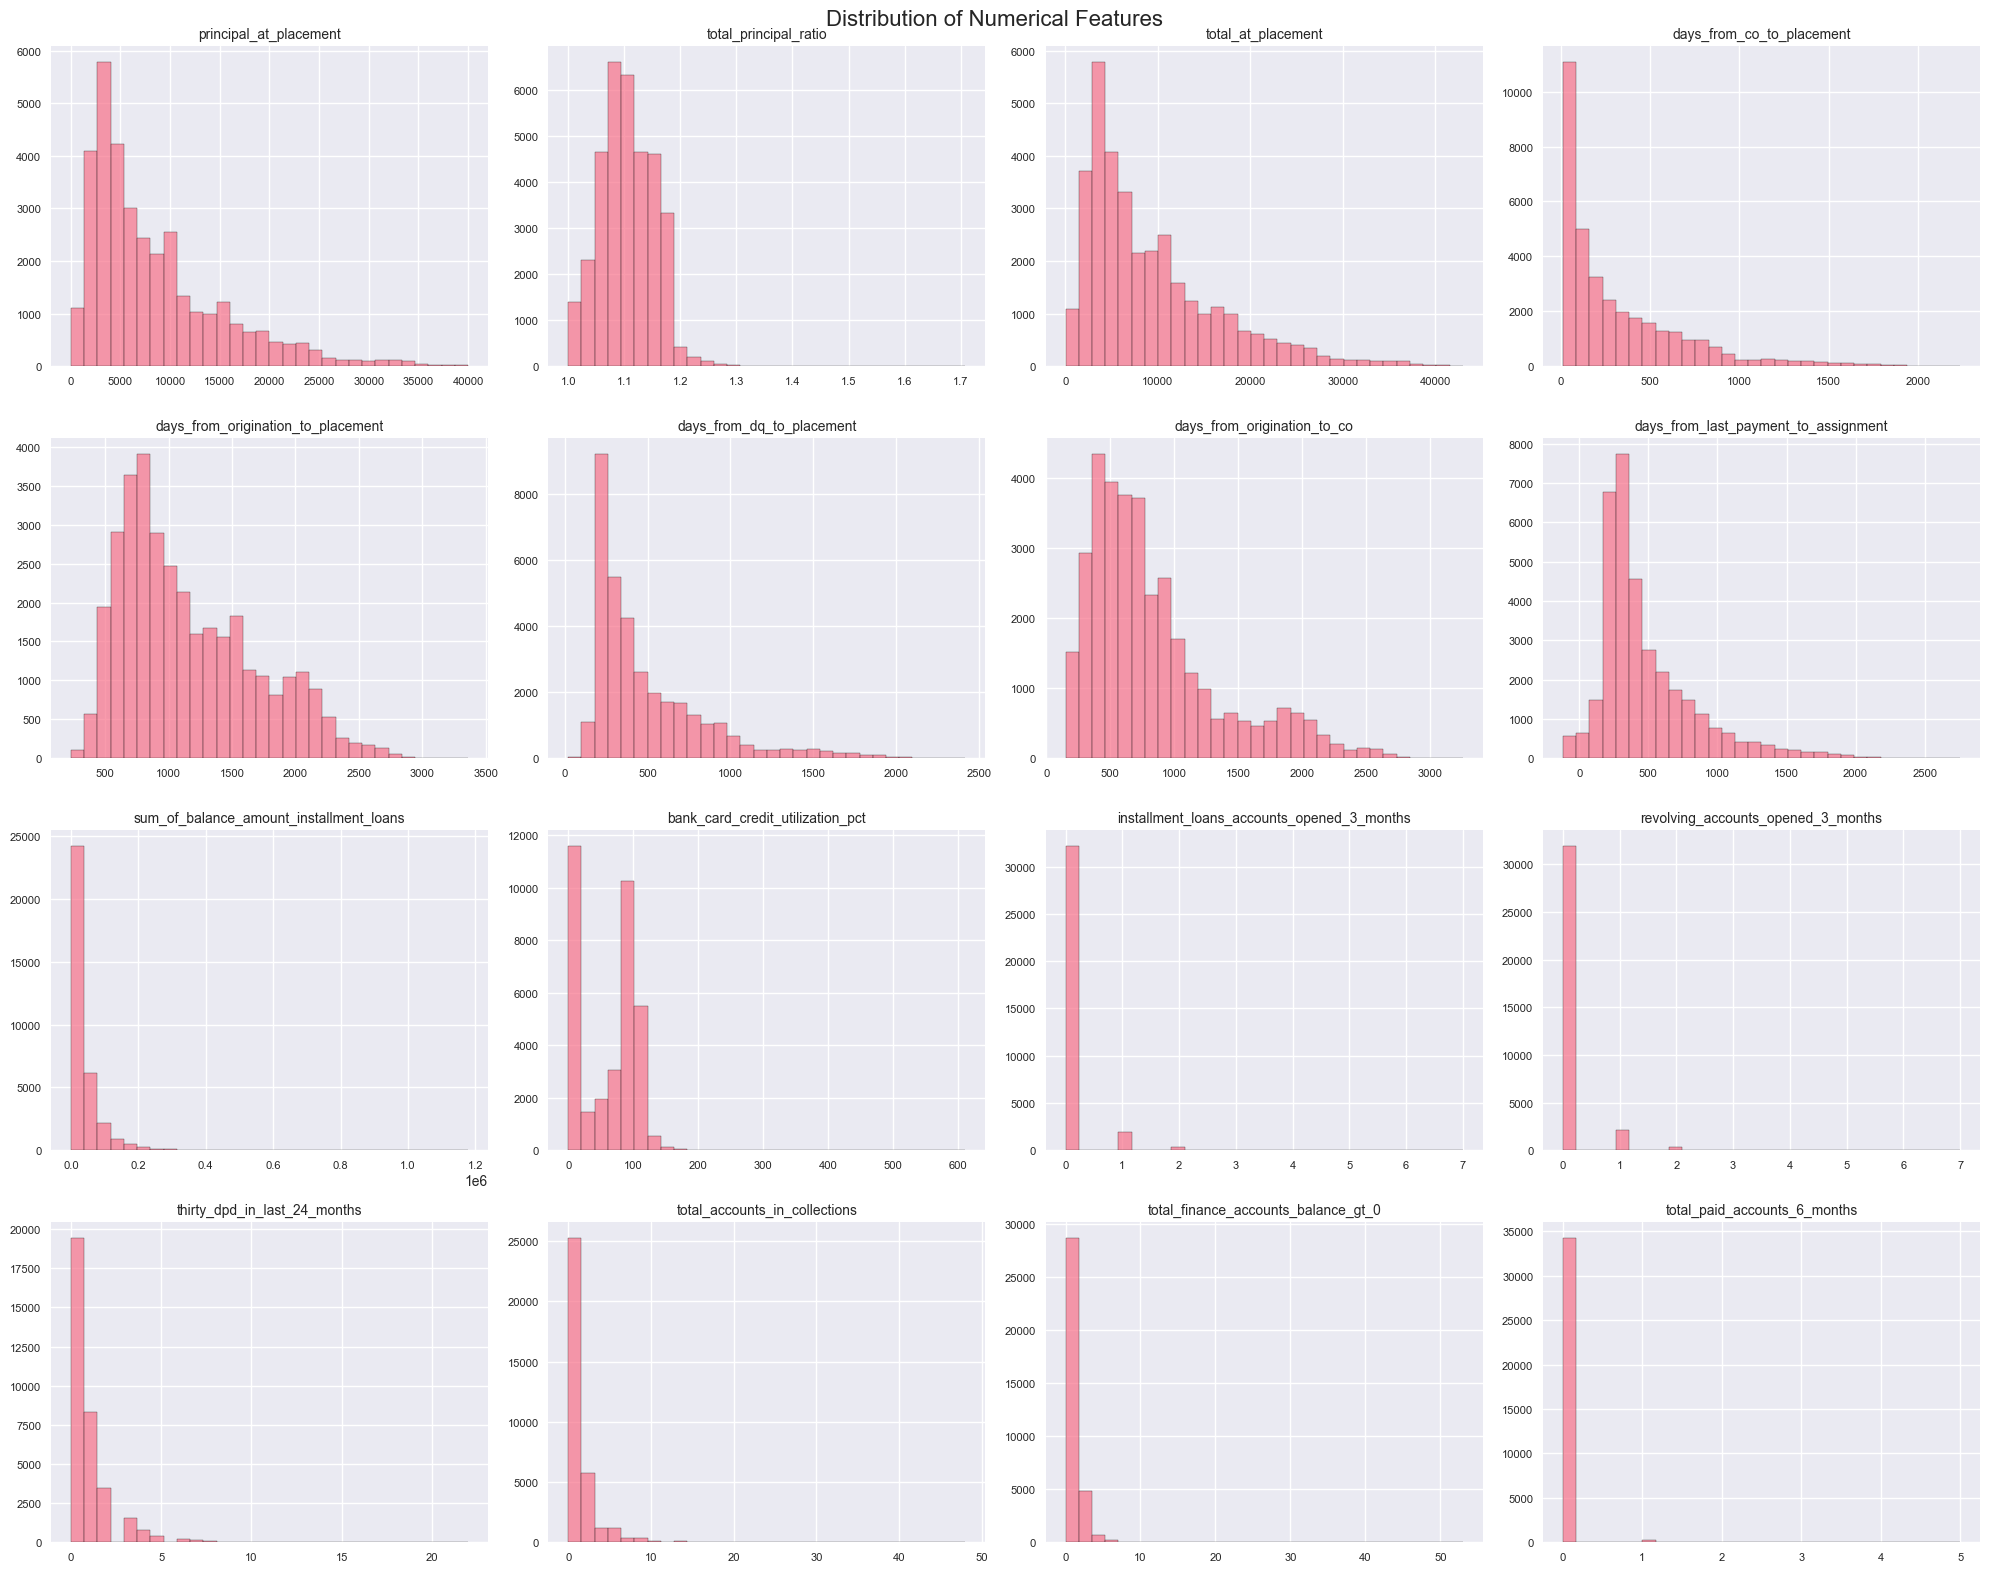


🔍 OUTLIER ANALYSIS (using IQR method):
                                   Feature  Outliers_Count  Outliers_Percentage      Q1       Q3      IQR
              thirty_dpd_in_last_24_months            3261                 9.42    0.00     1.00     1.00
        revolving_accounts_opened_3_months            2562                 7.40    0.00     0.00     0.00
       total_finance_accounts_balance_gt_0            2329                 6.73    0.00     1.00     1.00
installment_loans_accounts_opened_3_months            2300                 6.64    0.00     0.00     0.00
               days_from_origination_to_co            2245                 6.48  459.00  1036.00   577.00
   sum_of_balance_amount_installment_loans            2218                 6.41 2715.00 46025.50 43310.50
      days_from_last_payment_to_assignment            2028                 5.86  253.00   615.00   362.00
                 days_from_dq_to_placement            1846                 5.33  246.00   640.00   394.00
      

In [6]:
# Numerical features analysis
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"📊 NUMERICAL FEATURES ANALYSIS ({len(numerical_cols)} features)")
print("="*60)

# Distribution analysis
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:16]):  # Show first 16 numerical columns
    if idx < len(axes):
        df[col].hist(bins=30, ax=axes[idx], alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{col}', fontsize=10)
        axes[idx].set_xlabel('')
        axes[idx].tick_params(labelsize=8)

# Hide empty subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of Numerical Features', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Outlier detection using IQR
print("\n🔍 OUTLIER ANALYSIS (using IQR method):")
print("="*50)

outlier_summary = []
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_percentage = (len(outliers) / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outliers_Count': len(outliers),
        'Outliers_Percentage': outlier_percentage,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outliers_Percentage', ascending=False)
print(outlier_df.to_string(index=False, float_format='%.2f'))


### 5. Categorical Features Analysis


📊 CATEGORICAL FEATURES ANALYSIS (4 features)

🔍 Feature: account_public_id
------------------------------
Unique values: 34628
Most common value: BA-0669253639 (1 occurrences)

Top 5 values:
  BA-0669253639: 1 (0.00%)
  BA-4169596928: 1 (0.00%)
  BA-0435421191: 1 (0.00%)
  BA-1850540032: 1 (0.00%)
  BA-2694316032: 1 (0.00%)

🔍 Feature: is_fpd
------------------------------
Unique values: 2
Most common value: False (34,209 occurrences)

Value distribution:
  False: 34,209 (98.79%)
  True: 419 (1.21%)

🔍 Feature: group_
------------------------------
Unique values: 3
Most common value: B (21,307 occurrences)

Value distribution:
  B: 21,307 (61.53%)
  A: 11,107 (32.08%)
  B*: 2,214 (6.39%)

🔍 Feature: enrolled_to_plan_in_180
------------------------------
Unique values: 2
Most common value: False (27,191 occurrences)

Value distribution:
  False: 27,191 (78.52%)
  True: 5,223 (15.08%)


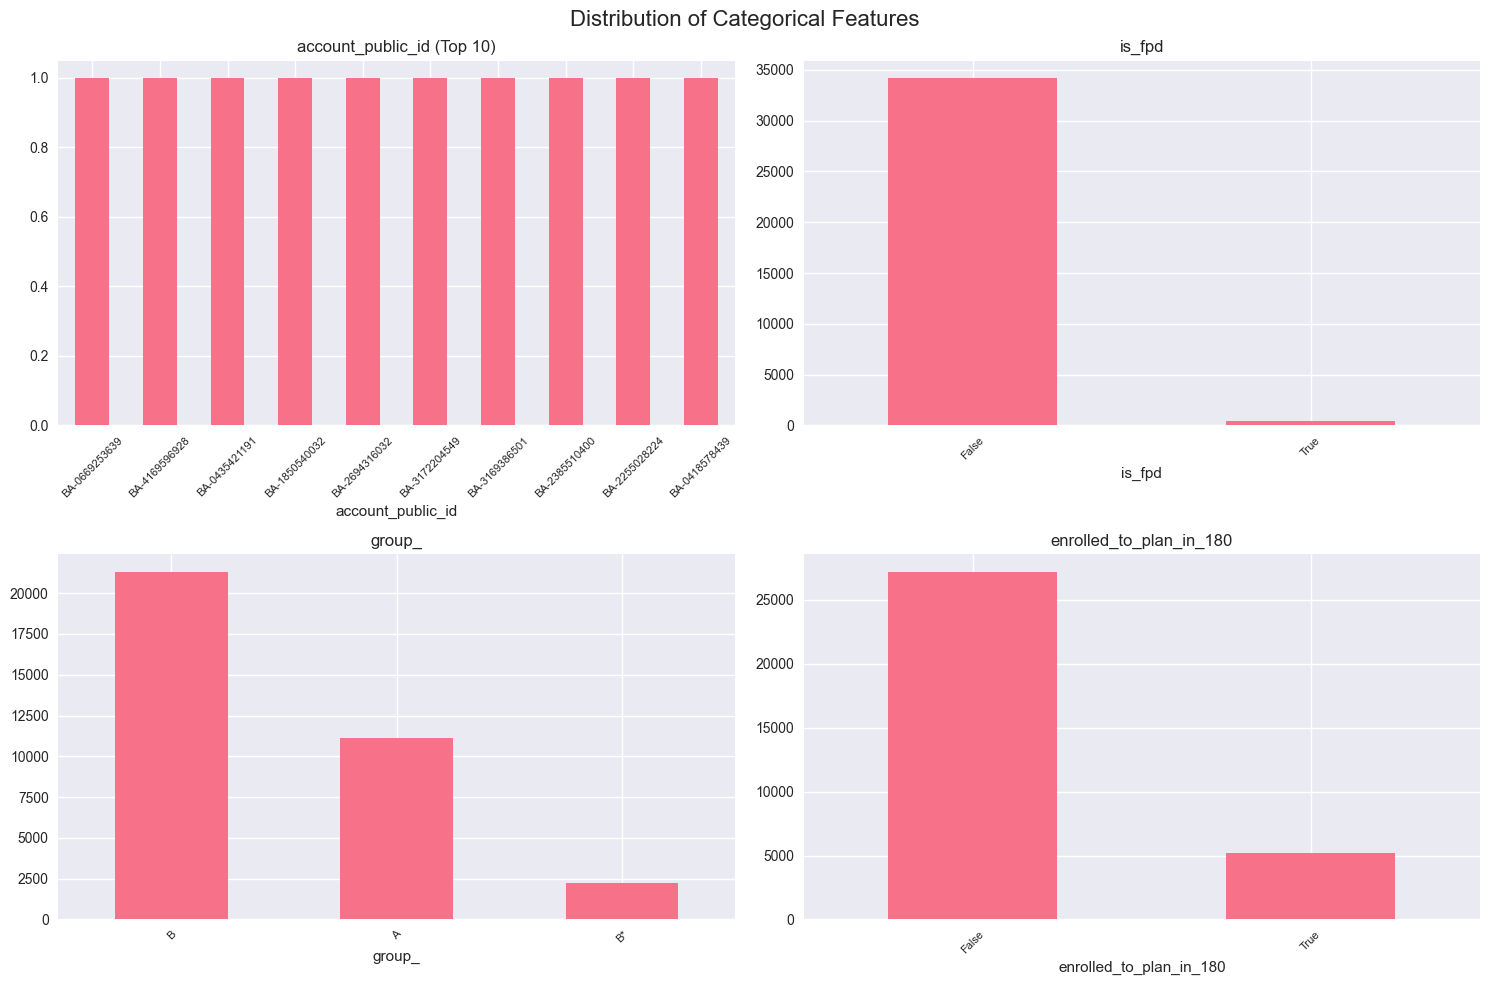

In [7]:
# Categorical features analysis
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"📊 CATEGORICAL FEATURES ANALYSIS ({len(categorical_cols)} features)")
print("="*60)

for col in categorical_cols:
    print(f"\n🔍 Feature: {col}")
    print("-" * 30)
    
    value_counts = df[col].value_counts()
    print(f"Unique values: {df[col].nunique()}")
    print(f"Most common value: {value_counts.index[0]} ({value_counts.iloc[0]:,} occurrences)")
    
    # Show value distribution if not too many unique values
    if df[col].nunique() <= 10:
        print("\nValue distribution:")
        for value, count in value_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {value}: {count:,} ({percentage:.2f}%)")
    else:
        print(f"\nTop 5 values:")
        for value, count in value_counts.head().items():
            percentage = (count / len(df)) * 100
            print(f"  {value}: {count:,} ({percentage:.2f}%)")

# Visualize categorical features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols[:4]):  # Show first 4 categorical columns
    if idx < len(axes):
        value_counts = df[col].value_counts()
        if len(value_counts) <= 10:  # Only plot if not too many categories
            value_counts.plot(kind='bar', ax=axes[idx])
            axes[idx].set_title(f'{col}')
            axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
        else:
            # Show top 10 for high cardinality features
            value_counts.head(10).plot(kind='bar', ax=axes[idx])
            axes[idx].set_title(f'{col} (Top 10)')
            axes[idx].tick_params(axis='x', rotation=45, labelsize=8)

# Hide empty subplots
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of Categorical Features', fontsize=16)
plt.tight_layout()
plt.show()


### 6. Correlation Analysis


🔗 CORRELATION ANALYSIS


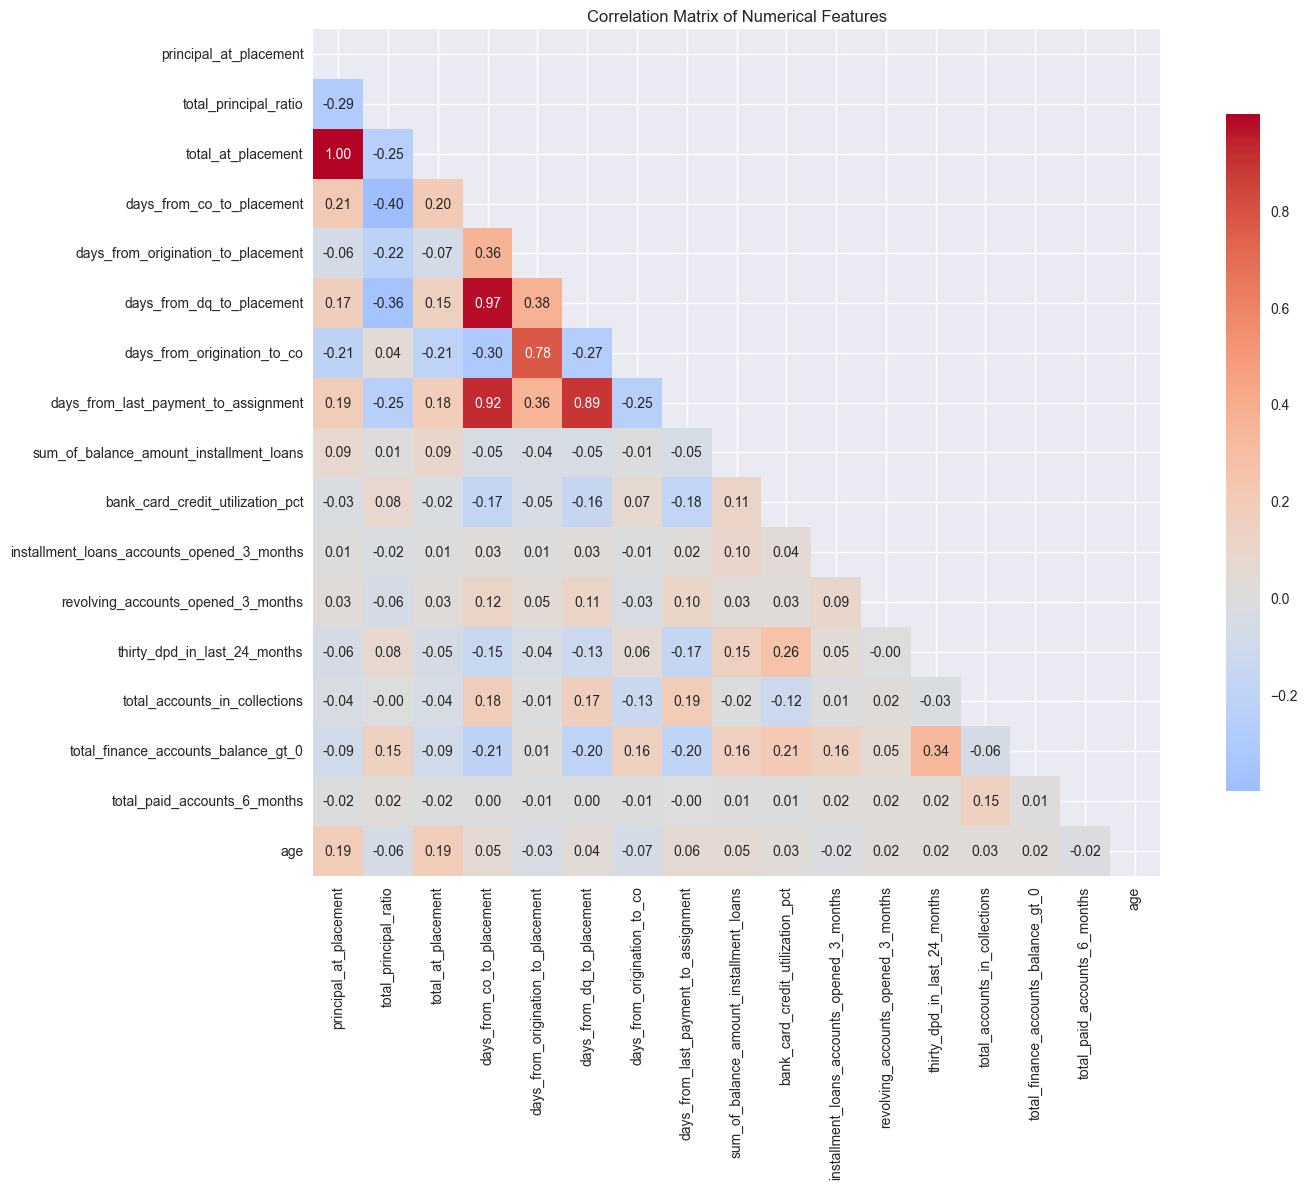


⚠️ HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.7):
                         Feature_1                            Feature_2  Correlation
            principal_at_placement                   total_at_placement        0.998
         days_from_co_to_placement            days_from_dq_to_placement        0.971
         days_from_co_to_placement days_from_last_payment_to_assignment        0.922
         days_from_dq_to_placement days_from_last_payment_to_assignment        0.889
days_from_origination_to_placement          days_from_origination_to_co        0.778


In [9]:
import numpy as np
# Correlation analysis
print("🔗 CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix for numerical features
correlation_matrix = df[numerical_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
           square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:  # High correlation threshold
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

if high_corr_pairs:
    print("\n⚠️ HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.7):")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False, float_format='%.3f'))
else:
    print("\n✅ No highly correlated feature pairs found (threshold: 0.7)")


### 7. Feature Relationship with Target Variable


🎯 FEATURE RELATIONSHIP WITH TARGET VARIABLE
Clean dataset shape: (32414, 21)
Target distribution after cleaning:
enrolled_to_plan_in_180
False    27191
True      5223
Name: count, dtype: int64

📊 NUMERICAL FEATURES vs TARGET:
----------------------------------------
                                   Feature  Correlation  Mean_Diff  Mean_True  Mean_False
                     total_principal_ratio      -0.1603    -0.0208     1.0856      1.1064
             total_accounts_in_collections      -0.1095    -0.6277     0.6689      1.2966
                    principal_at_placement       0.1036  1943.3720 10276.7591   8333.3871
               days_from_origination_to_co      -0.0986  -140.2441   746.9292    887.1733
                        total_at_placement       0.0968  1941.8106 11072.6519   9130.8414
        days_from_origination_to_placement      -0.0631   -90.7100  1117.6205   1208.3306
   sum_of_balance_amount_installment_loans       0.0581  7875.3701 40876.1700  33000.7999
             

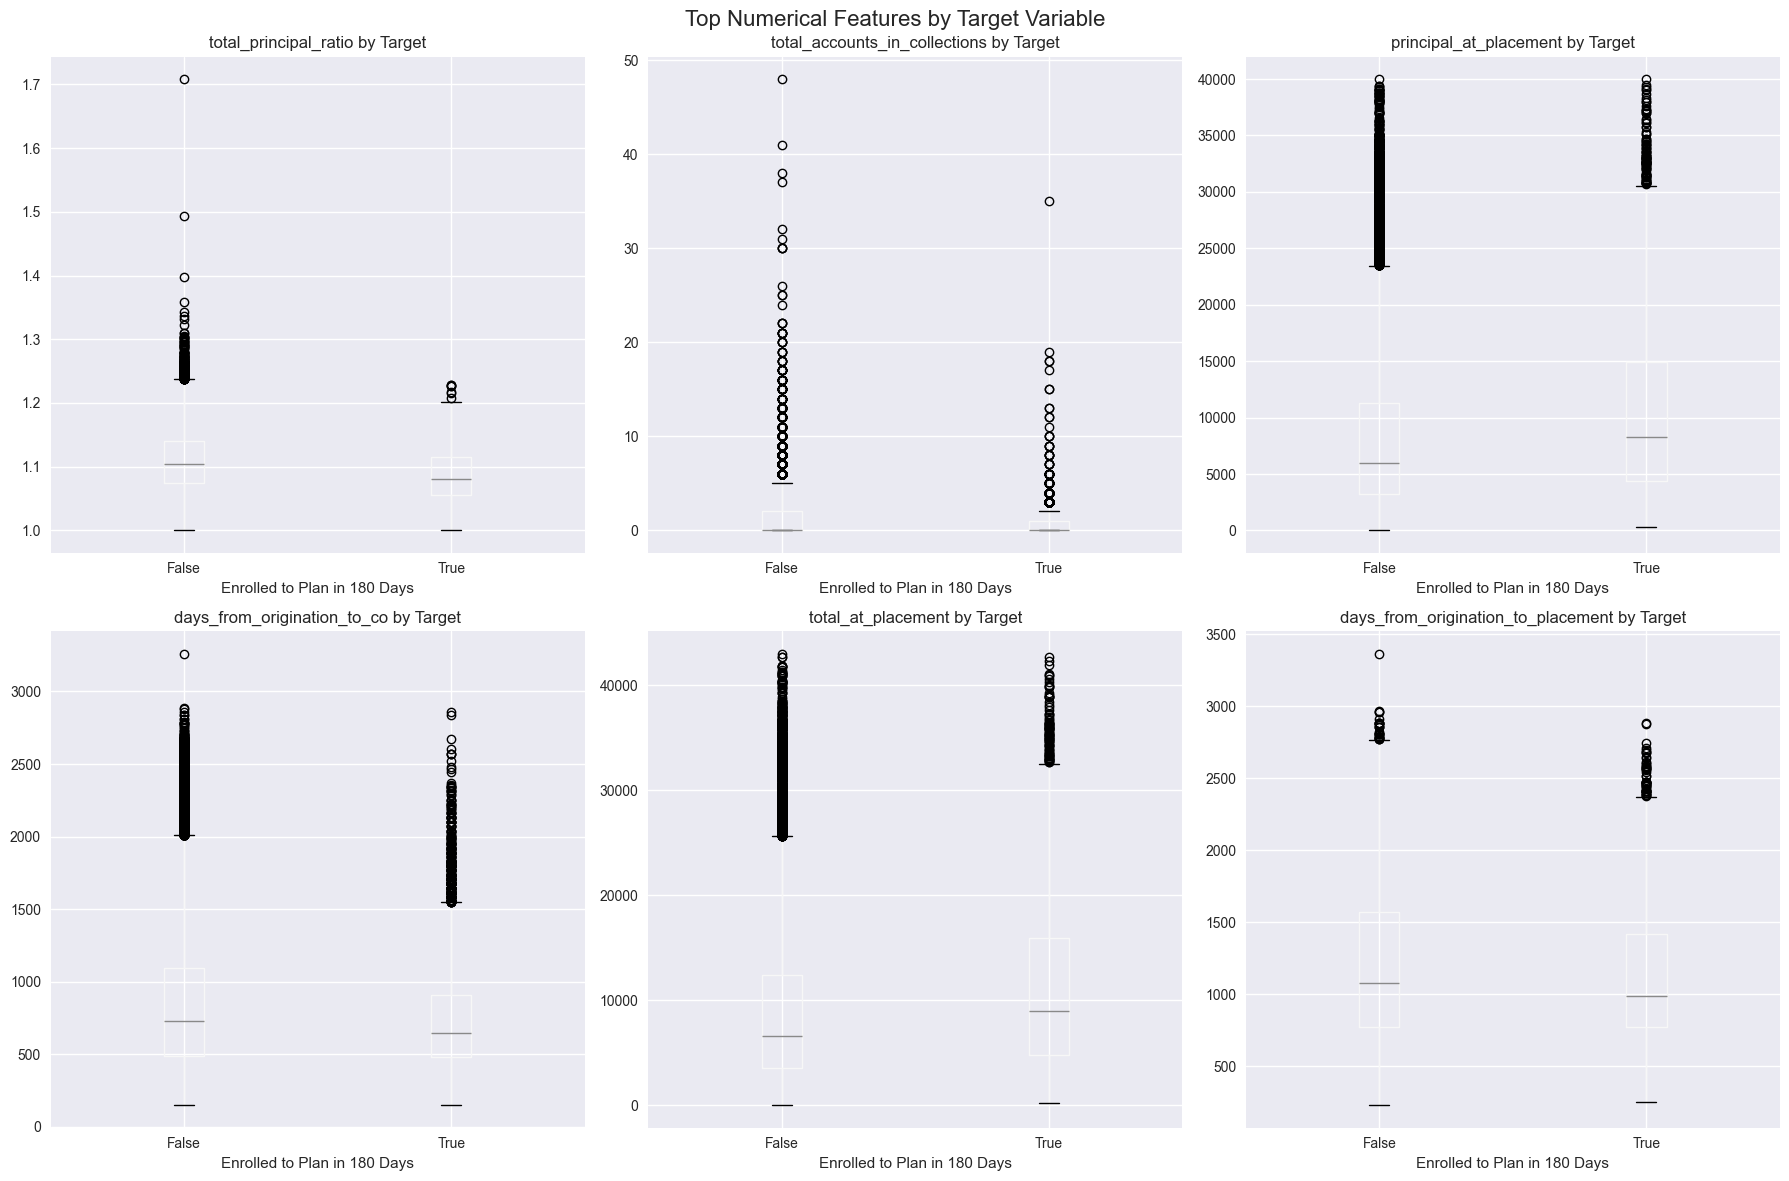


📊 CATEGORICAL FEATURES vs TARGET:
----------------------------------------
          Feature       Chi2  P_value  Cramers_V  Significant
account_public_id 32414.0000   0.4974     1.0000        False
           group_  1456.1809   0.0000     0.2120         True
           is_fpd    49.7865   0.0000     0.0392         True


In [12]:
# Feature relationship with target variable
import numpy as np
from scipy.stats import chi2_contingency

print("🎯 FEATURE RELATIONSHIP WITH TARGET VARIABLE")
print("="*60)

# Prepare clean data for analysis
df_analysis = df.dropna(subset=[target_col]).copy()

# Convert target to boolean if it's string
if df_analysis[target_col].dtype == 'object':
    # More robust target conversion
    df_analysis[target_col] = df_analysis[target_col].map({
        'True': True, 'False': False, 
        True: True, False: False,
        'true': True, 'false': False,
        1: True, 0: False
    })

# Remove any remaining NaN values after conversion
df_analysis = df_analysis.dropna(subset=[target_col]).copy()

# Ensure target is boolean
df_analysis[target_col] = df_analysis[target_col].astype(bool)

print(f"Clean dataset shape: {df_analysis.shape}")
print(f"Target distribution after cleaning:")
print(df_analysis[target_col].value_counts())

# Numerical features vs target
print("\n📊 NUMERICAL FEATURES vs TARGET:")
print("-" * 40)

numerical_target_corr = []
for col in numerical_cols:
    if col in df_analysis.columns:
        try:
            # Calculate correlation with target (convert boolean to int for correlation)
            target_numeric = df_analysis[target_col].astype(int)
            
            # Remove NaN values from both series before correlation
            valid_mask = df_analysis[col].notna() & target_numeric.notna()
            if valid_mask.sum() > 1:  # Need at least 2 valid values
                corr = df_analysis.loc[valid_mask, col].corr(target_numeric.loc[valid_mask])
            else:
                corr = np.nan
            
            # Calculate mean difference between groups
            group_means = df_analysis.groupby(target_col)[col].mean()
            mean_diff = group_means.get(True, 0) - group_means.get(False, 0) if len(group_means) >= 2 else 0
            
            numerical_target_corr.append({
                'Feature': col,
                'Correlation': corr,
                'Mean_Diff': mean_diff,
                'Mean_True': group_means.get(True, np.nan),
                'Mean_False': group_means.get(False, np.nan)
            })
        except Exception as e:
            print(f"Error processing {col}: {e}")
            numerical_target_corr.append({
                'Feature': col,
                'Correlation': np.nan,
                'Mean_Diff': np.nan,
                'Mean_True': np.nan,
                'Mean_False': np.nan
            })

numerical_corr_df = pd.DataFrame(numerical_target_corr).sort_values('Correlation', key=lambda x: abs(x), ascending=False)
print(numerical_corr_df.to_string(index=False, float_format='%.4f'))

# Visualize top correlated numerical features
top_numerical = numerical_corr_df.dropna(subset=['Correlation']).head(6)['Feature'].tolist()
if len(top_numerical) > 0:
    n_plots = min(6, len(top_numerical))
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, col in enumerate(top_numerical[:n_plots]):
        if idx < len(axes):
            # Box plot for each group
            df_analysis.boxplot(column=col, by=target_col, ax=axes[idx])
            axes[idx].set_title(f'{col} by Target')
            axes[idx].set_xlabel('Enrolled to Plan in 180 Days')

    # Hide empty subplots
    for idx in range(len(top_numerical), len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('Top Numerical Features by Target Variable', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No valid correlations found for visualization")

# Categorical features vs target
print(f"\n📊 CATEGORICAL FEATURES vs TARGET:")
print("-" * 40)

categorical_target_analysis = []
for col in categorical_cols:
    if col != target_col and col in df_analysis.columns:
        try:
            # Create contingency table
            contingency_table = pd.crosstab(df_analysis[col], df_analysis[target_col])
            
            # Check if contingency table has valid dimensions
            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                # Calculate Chi-square test
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                # Calculate Cramér's V (effect size)
                n = contingency_table.sum().sum()
                cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
                
                categorical_target_analysis.append({
                    'Feature': col,
                    'Chi2': chi2,
                    'P_value': p_value,
                    'Cramers_V': cramers_v,
                    'Significant': p_value < 0.05
                })
            else:
                print(f"Skipping {col}: insufficient variation for chi-square test")
        except Exception as e:
            print(f"Error processing {col}: {e}")
            categorical_target_analysis.append({
                'Feature': col,
                'Chi2': np.nan,
                'P_value': np.nan,
                'Cramers_V': np.nan,
                'Significant': False
            })

if categorical_target_analysis:
    categorical_df = pd.DataFrame(categorical_target_analysis).sort_values('Cramers_V', ascending=False)
    print(categorical_df.to_string(index=False, float_format='%.4f'))
else:
    print("No categorical features found for analysis")


### 8. Data Quality Assessment & Key Insights


In [13]:
# Data Quality Assessment & Key Insights
print("✅ DATA QUALITY ASSESSMENT")
print("="*60)

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count:,}")

# Check for constant features (zero variance)
constant_features = []
for col in numerical_cols:
    if df[col].nunique() == 1:
        constant_features.append(col)

print(f"Constant features (zero variance): {len(constant_features)}")
if constant_features:
    print(f"  - {', '.join(constant_features)}")

# Check data types consistency
print(f"\nData type distribution:")
print(df.dtypes.value_counts())

# Memory optimization suggestions
print(f"\n💾 MEMORY OPTIMIZATION SUGGESTIONS:")
print("-" * 40)

memory_suggestions = []
for col in df.columns:
    if df[col].dtype == 'int64':
        if df[col].min() >= 0 and df[col].max() <= 255:
            memory_suggestions.append(f"{col}: int64 → uint8")
        elif df[col].min() >= -128 and df[col].max() <= 127:
            memory_suggestions.append(f"{col}: int64 → int8")
        elif df[col].min() >= -32768 and df[col].max() <= 32767:
            memory_suggestions.append(f"{col}: int64 → int16")
    elif df[col].dtype == 'float64':
        if not df[col].isnull().any():
            # Check if can be converted to int
            if (df[col] % 1 == 0).all():
                memory_suggestions.append(f"{col}: float64 → int (all values are whole numbers)")

if memory_suggestions:
    print("Potential optimizations:")
    for suggestion in memory_suggestions[:10]:  # Show first 10
        print(f"  - {suggestion}")
else:
    print("No obvious memory optimizations available")

# Key Insights Summary
print(f"\n🔍 KEY INSIGHTS SUMMARY")
print("="*60)

insights = []

# Target distribution insight
target_dist = df_analysis[target_col].value_counts(normalize=True)
if len(target_dist) >= 2:
    enrollment_rate = target_dist.get(True, 0) * 100
    insights.append(f"📈 Overall enrollment rate: {enrollment_rate:.1f}%")

# Missing data insight
missing_features = missing_data['Column'].tolist() if len(missing_data) > 0 else []
if missing_features:
    insights.append(f"⚠️ {len(missing_features)} features have missing values")

# High correlation insight
if 'high_corr_df' in locals() and len(high_corr_df) > 0:
    insights.append(f"🔗 {len(high_corr_df)} highly correlated feature pairs found")

# Outliers insight
high_outlier_features = outlier_df[outlier_df['Outliers_Percentage'] > 5]['Feature'].tolist()
if high_outlier_features:
    insights.append(f"📊 {len(high_outlier_features)} features have >5% outliers")

# Most predictive features
if 'numerical_corr_df' in locals():
    top_predictive = numerical_corr_df.head(3)['Feature'].tolist()
    insights.append(f"🎯 Most predictive numerical features: {', '.join(top_predictive)}")

# Print insights
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print(f"\n🎉 EDA COMPLETE! Dataset is ready for modeling.")
print(f"📝 Next steps: Feature engineering and model training")


✅ DATA QUALITY ASSESSMENT
Duplicate rows: 0
Constant features (zero variance): 0

Data type distribution:
float64    11
int64       6
object      3
bool        1
Name: count, dtype: int64

💾 MEMORY OPTIMIZATION SUGGESTIONS:
----------------------------------------
Potential optimizations:
  - days_from_co_to_placement: int64 → int16
  - days_from_origination_to_placement: int64 → int16
  - days_from_dq_to_placement: int64 → int16
  - days_from_origination_to_co: int64 → int16
  - days_from_last_payment_to_assignment: int64 → int16
  - age: int64 → uint8

🔍 KEY INSIGHTS SUMMARY
1. 📈 Overall enrollment rate: 16.1%
2. ⚠️ 9 features have missing values
3. 🔗 5 highly correlated feature pairs found
4. 📊 8 features have >5% outliers
5. 🎯 Most predictive numerical features: total_principal_ratio, total_accounts_in_collections, principal_at_placement

🎉 EDA COMPLETE! Dataset is ready for modeling.
📝 Next steps: Feature engineering and model training
